## 1. Import Libraries

In [12]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision.transforms import v2 as transforms
from torch.utils.data import TensorDataset, DataLoader
from torchview import draw_graph

# Configurazione di TensorBoard e directory
logs_dir = "tensorboard"
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import cv2
import copy
import shutil
from itertools import product
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.gridspec as gridspec
import requests
from io import BytesIO
from tqdm import tqdm
import glob
from pathlib import Path

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
PyTorch version: 2.5.1
Device: cuda


A subdirectory or file models already exists.
Error occurred while processing: models.


## **2. Data Loading**

In [13]:
USE_UNMASKED = False  # @param {type:"boolean"}

In [14]:
datasets_path = os.path.join(os.path.pardir, "an2dl2526c2")

train_data_path = os.path.join(datasets_path, "train_data")
train_labels_path = os.path.join(datasets_path, "train_labels.csv")

test_data_path = os.path.join(datasets_path, "test_data")

output_path = os.path.join(datasets_path, "train_masked")

if USE_UNMASKED:
    resized_path = os.path.join(datasets_path, "train_resized")

print(f"Dataset path: {datasets_path}")
print(f"Train data path: {train_data_path}")
print(f"Train labels path: {train_labels_path}")
print(f"Test data path: {test_data_path}")
print(f"Output path: {output_path}")
if USE_UNMASKED:
    print(f"Resized path: {resized_path}")

CSV_PATH = train_labels_path                # Path to the CSV file with labels
SOURCE_FOLDER = train_data_path             # Folder containing img_xxxx and mask_xxxx
OUTPUT_FOLDER = output_path
if USE_UNMASKED:                   # Where the resized and masked images will be saved            
    RESIZED_FOLDER = resized_path               # Where the resized unmasked images will be saved

TARGET_SIZE = (224, 224)                    # Target size for the resized images and masks

Dataset path: ..\an2dl2526c2
Train data path: ..\an2dl2526c2\train_data
Train labels path: ..\an2dl2526c2\train_labels.csv
Test data path: ..\an2dl2526c2\test_data
Output path: ..\an2dl2526c2\train_masked


In [40]:
# Define constants for goo detection
CORE_LOWER = np.array([35, 100, 50]) 
CORE_UPPER = np.array([85, 255, 255])
SHELL_LOWER = np.array([30, 30, 30]) 
SHELL_UPPER = np.array([95, 255, 255])
MIN_GOO_AREA = 200

def get_smart_goo_mask(img):
    """
    Detects green goo using a core-shell strategy in HSV space.
    Returns a binary mask where 255 = goo, 0 = clean tissue.
    """
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) # Note: OpenCV loads as BGR

    mask_core = cv2.inRange(hsv, CORE_LOWER, CORE_UPPER)
    mask_shell = cv2.inRange(hsv, SHELL_LOWER, SHELL_UPPER)

    # Combine shell blobs that overlap with core
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask_shell, connectivity=8)
    smart_mask = np.zeros_like(mask_core)
    
    for label_id in range(1, num_labels):
        blob_mask = (labels == label_id).astype(np.uint8) * 255
        overlap = cv2.bitwise_and(blob_mask, mask_core)
        if cv2.countNonZero(overlap) > 0:
            smart_mask = cv2.bitwise_or(smart_mask, blob_mask)
            
    # Fill holes and filter by area
    contours, _ = cv2.findContours(smart_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    final_filled_mask = np.zeros_like(smart_mask)
    for contour in contours:
        if cv2.contourArea(contour) > MIN_GOO_AREA:
            cv2.drawContours(final_filled_mask, [contour], -1, (255), thickness=cv2.FILLED)

    # Dilate by 1 pixel for safety
    kernel = np.ones((3, 3), np.uint8)
    final_expanded_mask = cv2.dilate(final_filled_mask, kernel, iterations=1)
    
    return final_expanded_mask

def apply_mask(image_path, mask_path, output_path, target_size=(224, 224)):
    """
    Loads an image and a mask, removes green goo, applies the cleaned mask,
    resizes, and saves the result.
    """
    # 1. Load Image
    img = cv2.imread(str(image_path))
    if img is None:
        tqdm.write(f"Error: Could not load image at {image_path}")
        return

    # 2. Load Original Mask (Read as grayscale)
    mask = cv2.imread(str(mask_path), 0)
    if mask is None:
        # Fallback: if mask is missing, treat whole image as ROI but still remove goo
        mask = np.full(img.shape[:2], 255, dtype=np.uint8)

    # 3. Detect and Remove Green Goo
    goo_mask = get_smart_goo_mask(img)
    
    # Logic: Valid Tissue = Original_Mask AND (NOT Goo_Mask)
    # This effectively punches holes in the original mask wherever goo is detected
    cleaned_mask = cv2.bitwise_and(mask, cv2.bitwise_not(goo_mask))

    # 4. Resize both to target size
    if target_size is not None:
        # Resize image using linear interpolation (better for photos)
        img = cv2.resize(img, target_size)
        # Resize mask using nearest neighbor to preserve sharp edges
        cleaned_mask = cv2.resize(cleaned_mask, target_size, interpolation=cv2.INTER_NEAREST)

    # 5. Ensure mask is strictly binary (0 or 255)
    _, binary_mask = cv2.threshold(cleaned_mask, 127, 255, cv2.THRESH_BINARY)

    # 6. Apply the mask
    # cv2.bitwise_and keeps the pixel where the mask is 255, and makes it 0 where mask is 0
    masked_img = cv2.bitwise_and(img, img, mask=binary_mask)

    # 7. Save result
    cv2.imwrite(str(output_path), masked_img)

In [58]:
def process_batch(input_dir, output_dir, target_size=(224, 224)):
    """
    Iterates through input_dir, finds pairs of 'img_xxxx' and 'mask_xxxx',
    resizes them to target_size, and saves the masked result to output_dir.
    """
    input_dir = Path(input_dir)
    output_dir = Path(output_dir)
    
    # Create output directory if it doesn't exist
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Extensions to look for
    valid_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff'}
    
    # 1. Gather all valid image files first
    print(f"Scanning for images in: {input_dir}...")
    image_files = [
        f for f in input_dir.iterdir() 
        if f.name.startswith('img_') and f.suffix.lower() in valid_extensions
    ]
    
    if not image_files:
        print("No images found starting with 'img_' in the directory.")
        return

    # 2. Iterate with tqdm
    count = 0
    
    for file_path in tqdm(image_files, desc="Processing Images", unit="img"):
        # Construct expected mask filename: img_123.jpg -> mask_123.jpg
        mask_name = file_path.name.replace('img_', 'mask_', 1)
        mask_path = input_dir / mask_name
        
        # Fallback: If mask_123.jpg doesn't exist, try mask_123.png
        if not mask_path.exists():
            mask_stem = file_path.stem.replace('img_', 'mask_', 1)
            mask_path = input_dir / (mask_stem + ".png")
        
        if mask_path.exists():
            output_path = output_dir / file_path.name
            
            # NOTE: We overwrite existing files to ensure the GOO FILTER is applied
            # if output_path.exists(): continue 

            apply_mask(file_path, mask_path, output_path, target_size=target_size)
            count += 1
        else:
            tqdm.write(f"Skipping {file_path.name}: No matching mask found (looked for {mask_name})")

    print(f"Batch processing complete. Processed {count} new images.")

def resize_batch(input_dir, output_dir, target_size=(224, 224)):
    """
    Iterates through input_dir, finds 'img_xxxx', removes GREEN GOO, 
    resizes them to target_size, and saves the result to output_dir.
    """
    input_dir = Path(input_dir)
    output_dir = Path(output_dir)
    
    # Create output directory if it doesn't exist
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Extensions to look for
    valid_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff'}
    
    # 1. Gather all valid image files first
    print(f"Scanning for images in: {input_dir}...")
    image_files = [
        f for f in input_dir.iterdir() 
        if f.name.startswith('img_') and f.suffix.lower() in valid_extensions
    ]
    
    if not image_files:
        print("No images found starting with 'img_' in the directory.")
        return

    # 2. Iterate with tqdm
    count = 0
    
    for file_path in tqdm(image_files, desc="Resizing (and Cleaning) Images", unit="img"):
        output_path = output_dir / file_path.name
        
        # NOTE: We overwrite existing files to ensure the GOO FILTER is applied
        # if output_path.exists(): continue

        img = cv2.imread(str(file_path))
        if img is None:
            continue
        
        # --- NEW: Apply Goo Filter even for unmasked images ---
        # get_smart_goo_mask is defined in Cell 15
        goo_mask = get_smart_goo_mask(img)
        
        # Invert mask: we want to KEEP pixels that are NOT goo
        clean_mask = cv2.bitwise_not(goo_mask)
        
        # Black out the goo
        img = cv2.bitwise_and(img, img, mask=clean_mask)
        # ------------------------------------------------------

        if target_size is not None:
            img = cv2.resize(img, target_size)
            
        cv2.imwrite(str(output_path), img)
        count += 1

    print(f"Resizing complete. Processed {count} new images.")

In [59]:
def load_images_from_folder(folder, resize=None, filter_prefix=None):
    """
    Load and preprocess images from a specified folder with a progress bar.

    Args:
        folder (str): Path to the folder containing images
        resize (tuple): Target size (width, height) or None
        filter_prefix (str): Prefix to filter filenames (e.g. 'img_')

    Returns:
        tuple: (np.ndarray of images, list of filenames)
    """
    images = []
    loaded_filenames = []
    
    # Get the list of files to iterate over
    file_list = sorted(os.listdir(folder))
    
    # Filter files before iterating to show correct progress
    if filter_prefix:
        file_list = [f for f in file_list if f.startswith(filter_prefix)]

    # Iterate through files with a tqdm progress bar
    for filename in tqdm(file_list, desc=f"Loading images from {os.path.basename(folder)}"):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)

        # Check if image was loaded successfully right away
        if img is None:
            # print(f"Warning: Failed to load image at {img_path}. Skipping.")
            continue

        # Normalize image pixel values to a float range [0, 1]
        img = (img / 255.0).astype(np.float32)

        # Convert image from BGR to RGB
        img = img[..., ::-1]

        if resize:
            img = cv2.resize(img, resize)

        images.append(img)
        loaded_filenames.append(filename)

    return np.array(images), loaded_filenames

In [60]:
process_batch(SOURCE_FOLDER, OUTPUT_FOLDER, target_size=TARGET_SIZE)
MASKED_IMAGE_PATH = OUTPUT_FOLDER
if USE_UNMASKED:
    resize_batch(SOURCE_FOLDER, RESIZED_FOLDER, target_size=TARGET_SIZE)
    RESIZED_IMAGE_PATH = RESIZED_FOLDER

Scanning for images in: ..\an2dl2526c2\train_data...


Processing Images: 100%|██████████| 1412/1412 [01:36<00:00, 14.66img/s]

Batch processing complete. Processed 1412 new images.


In [61]:
# Load masked images (already resized in process_batch)
# We add filter_prefix='img_' to ensure we don't load any mask files that might be in the folder
masked_images, masked_filenames = load_images_from_folder(MASKED_IMAGE_PATH, filter_prefix='img_')

# Load original images (already resized in resize_batch)
if USE_UNMASKED:
    original_images, original_filenames = load_images_from_folder(RESIZED_IMAGE_PATH, filter_prefix='img_')
    # Combine images
    train_images = np.concatenate([masked_images, original_images], axis=0)
    # Combine filenames
    filenames = masked_filenames + original_filenames
else:
    original_images = []
    train_images = masked_images
    filenames = masked_filenames


print(f"Loaded {len(masked_images)} masked images and {len(original_images)} original images.")
print(f"Total images: {len(train_images)}")

Loading images from train_masked: 100%|██████████| 1412/1412 [00:13<00:00, 103.50it/s]


Loaded 1412 masked images and 0 original images.
Total images: 1412


## **3. Exploration and Data Analysis**

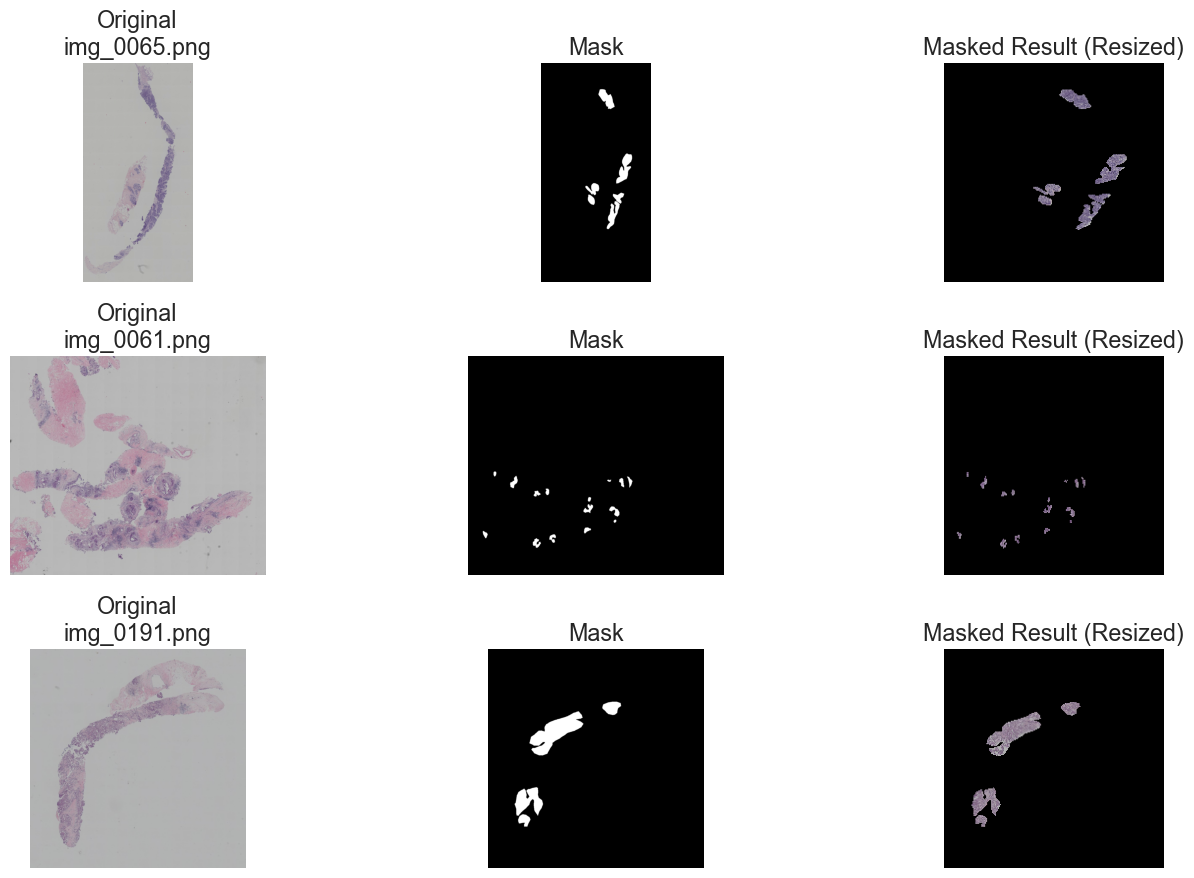

In [62]:
#@ title Mask Verification
# Select a few random images from the output folder to verify the process
masked_files = os.listdir(OUTPUT_FOLDER)
num_samples = 3
selected_files = random.sample(masked_files, num_samples)

fig, axes = plt.subplots(num_samples, 3, figsize=(15, 3 * num_samples))

for i, filename in enumerate(selected_files):
    # 1. Define paths
    masked_image_path = os.path.join(OUTPUT_FOLDER, filename)
    original_image_path = os.path.join(SOURCE_FOLDER, filename)
    
    # Logic to find the mask path (replicating logic from Cell 5)
    mask_name = filename.replace('img_', 'mask_', 1)
    mask_path = os.path.join(SOURCE_FOLDER, mask_name)
    
    # Check if mask exists, if not try .png fallback as per Cell 5 logic
    if not os.path.exists(mask_path):
        mask_stem = os.path.splitext(filename)[0].replace('img_', 'mask_', 1)
        mask_path = os.path.join(SOURCE_FOLDER, mask_stem + ".png")

    # 2. Load images
    # Original
    orig_img = cv2.imread(original_image_path)
    if orig_img is not None:
        orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    
    # Mask
    mask_img = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    # Masked (Result)
    masked_img = cv2.imread(masked_image_path)
    if masked_img is not None:
        masked_img = cv2.cvtColor(masked_img, cv2.COLOR_BGR2RGB)

    # 3. Plot
    # Original
    if orig_img is not None:
        axes[i, 0].imshow(orig_img)
        axes[i, 0].set_title(f"Original\n{filename}")
    else:
        axes[i, 0].text(0.5, 0.5, "Original Not Found", ha='center')
    axes[i, 0].axis('off')

    # Mask
    if mask_img is not None:
        axes[i, 1].imshow(mask_img, cmap='gray')
        axes[i, 1].set_title(f"Mask")
    else:
        axes[i, 1].text(0.5, 0.5, "Mask Not Found", ha='center')
    axes[i, 1].axis('off')

    # Masked
    if masked_img is not None:
        axes[i, 2].imshow(masked_img)
        axes[i, 2].set_title(f"Masked Result (Resized)")
    else:
        axes[i, 2].text(0.5, 0.5, "Result Not Found", ha='center')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

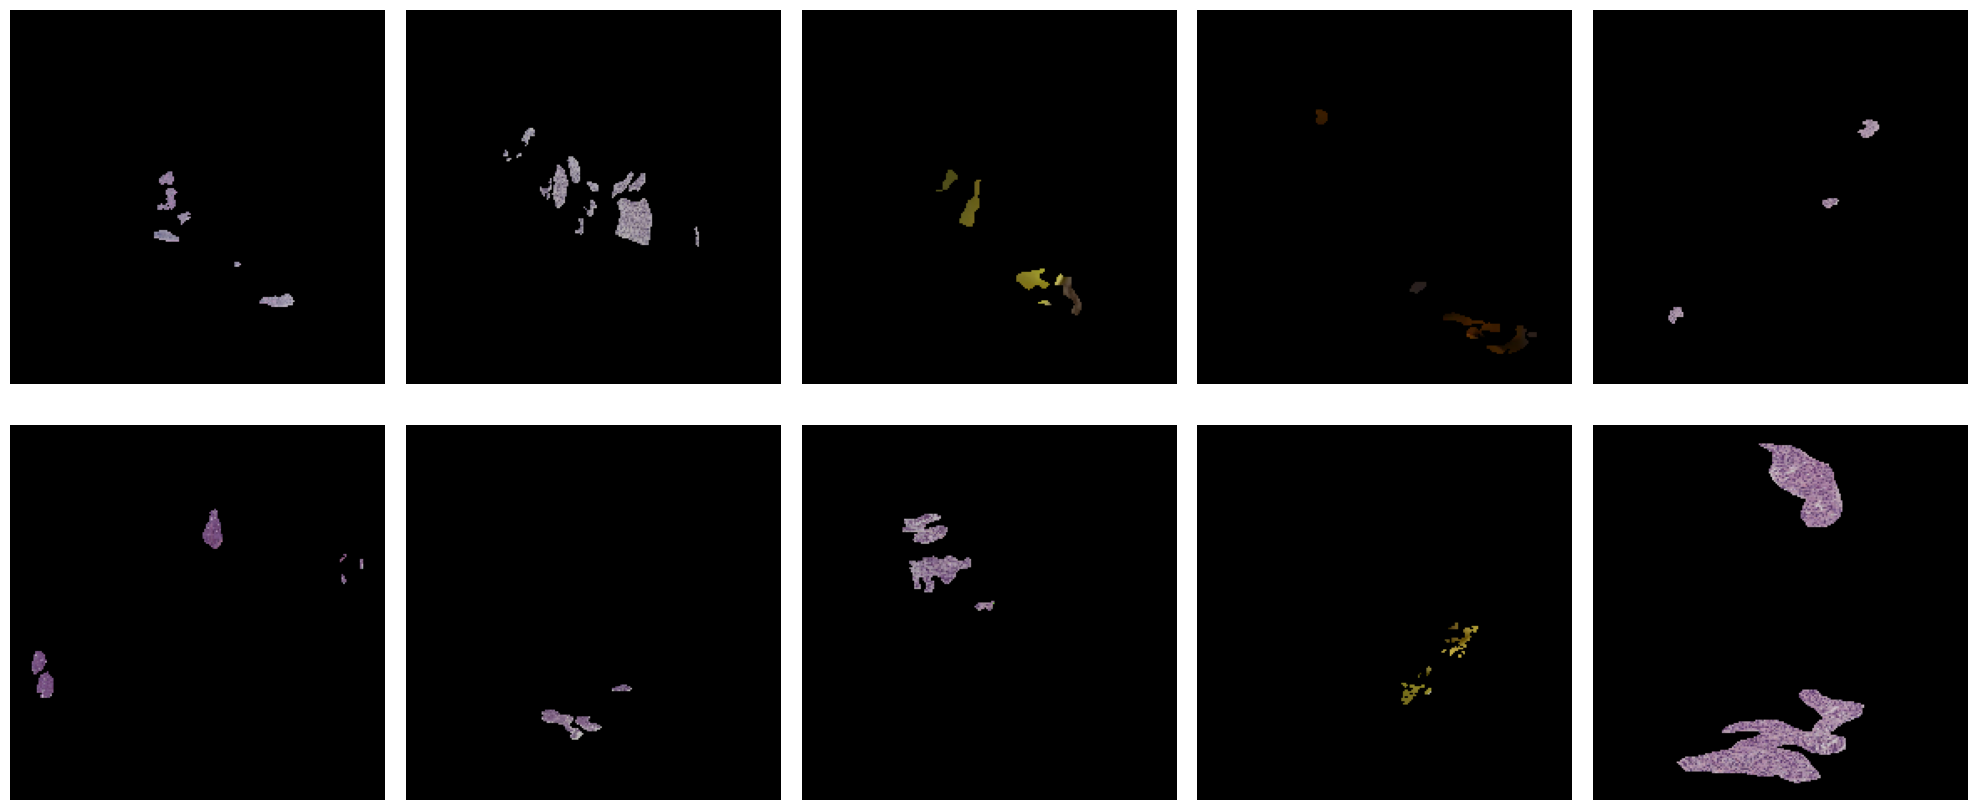

In [63]:
# Number of images to display
num_img = 10
# Starting index
start_img= random.randint(0, len(train_images) - num_img)
# Create subplots for displaying items
fig, axes = plt.subplots(2, num_img//2, figsize=(20, 9))
for i in range(start_img, start_img+num_img):
    ax = axes[i%2, i%num_img//2]
    ax.imshow(np.clip(train_images[i], 0, 1))  # Display clipped item images
    ax.axis('off')
plt.tight_layout()
plt.show()



In [64]:
from sklearn.preprocessing import LabelEncoder

# 1. Load the labels CSV
labels_df = pd.read_csv(train_labels_path)
# Create a dictionary mapping filename -> label for fast lookup
labels_map = dict(zip(labels_df.iloc[:, 0], labels_df.iloc[:, 1]))

# 2. Get the filenames corresponding to the images loaded in Cell 7
# IMPORTANT: This must match the order used in 'load_images_from_folder' exactly.
# We use the filenames list created in the previous cell.
# filenames = os.listdir(MASKED_IMAGE_PATH)

print("Aligning labels to loaded images...")

X_aligned = []
y_aligned = []

# 3. Iterate through the filenames to sync X (images) and y (labels)
# We assume 'train_images' matches the order of 'filenames' because they rely on the same os.listdir call order
# provided no files were added/deleted between Cell 7 and Cell 9.
if len(filenames) != len(train_images):
    raise ValueError(f"Mismatch! Loaded images ({len(train_images)}) != Files found ({len(filenames)}).")

for i, filename in enumerate(filenames):
    if filename in labels_map:
        # If the file exists in our CSV, keep the image and the label
        X_aligned.append(train_images[i])
        y_aligned.append(labels_map[filename])
    else:
        # If image is in folder but NOT in CSV, we must discard the image
        print(f"Skipping {filename}: Image found but no label in CSV.")

# Convert to numpy arrays
X = np.array(X_aligned)
y = np.array(y_aligned)

print(f"Images aligned: {X.shape}")
print(f"Labels aligned: {y.shape}")

# 4. Encode labels (String -> Integer)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Print class mapping
print("Classes:", label_encoder.classes_)

# 5. Train-Test Split (Stratified)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_encoded, 
    test_size=0.2, 
    random_state=SEED, 
    stratify=y_encoded
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=SEED,
    stratify=y_temp
)

print(f"Training data shape: {X_train.shape}, Labels: {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, Labels: {y_val.shape}")
print(f"Test data shape: {X_test.shape}, Labels: {y_test.shape}")

Aligning labels to loaded images...
Images aligned: (1412, 224, 224, 3)
Labels aligned: (1412,)
Classes: ['HER2(+)' 'Luminal A' 'Luminal B' 'Triple negative']
Training data shape: (1129, 224, 224, 3), Labels: (1129,)
Validation data shape: (141, 224, 224, 3), Labels: (141,)
Test data shape: (142, 224, 224, 3), Labels: (142,)


In [65]:
# Define the input shape based on the training data
input_shape = (X_train.shape[3], X_train.shape[1], X_train.shape[2])

# Define the number of classes
num_classes = len(np.unique(y_train))

print("Input Shape:", input_shape)
print("Number of Classes:", num_classes)

Input Shape: (3, 224, 224)
Number of Classes: 4


In [66]:
# Convert numpy arrays to PyTorch datasets (without augmentation for now)
train_ds = TensorDataset(
    torch.from_numpy(X_train).permute(0, 3, 1, 2),
    torch.from_numpy(y_train).squeeze().long()
)
val_ds = TensorDataset(
    torch.from_numpy(X_val).permute(0, 3, 1, 2),
    torch.from_numpy(y_val).squeeze().long()
)
test_ds = TensorDataset(
    torch.from_numpy(X_test).permute(0, 3, 1, 2),
    torch.from_numpy(y_test).squeeze().long()
)

In [67]:
# Define the batch size
BATCH_SIZE = 32

In [68]:
def make_loader(ds, batch_size, shuffle, drop_last):
    """
    Create a PyTorch DataLoader with optimized settings.

    Args:
        ds (Dataset): PyTorch Dataset object
        batch_size (int): Number of samples per batch
        shuffle (bool): Whether to shuffle data at each epoch
        drop_last (bool): Whether to drop last incomplete batch

    Returns:
        DataLoader: Configured DataLoader instance
    """
    # Determine optimal number of worker processes for data loading
    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, min(4, cpu_cores))

    # Create DataLoader with performance optimizations
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,  # Faster GPU transfer
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=4,  # Load 4 batches ahead
    )

In [69]:
# Create data loaders with different settings for each phase
train_loader = make_loader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader = make_loader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
test_loader = make_loader(test_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [70]:
# Get one batch from the training data loader
for xb, yb in train_loader:
    print("Features batch shape:", xb.shape)
    print("Labels batch shape:", yb.shape)
    break  # Stop after getting one batch

Features batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])


## **4. Training Parameters**

In [71]:
# Number of training epochs
LEARNING_RATE = 1e-3
EPOCHS = 1000
PATIENCE = 50

# Regularisation
DROPOUT_RATE = 0.2         # Dropout probability
L1_LAMBDA = 0            # L1 penalty
L2_LAMBDA = 0            # L2 penalty

# Set up loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Print the defined parameters
print("Epochs:", EPOCHS)
print("Batch Size:", BATCH_SIZE)
print("Learning Rare:", LEARNING_RATE)
print("Dropout Rate:", DROPOUT_RATE)
print("L1 Penalty:", L1_LAMBDA)
print("L2 Penalty:", L2_LAMBDA)

Epochs: 1000
Batch Size: 32
Learning Rare: 0.001
Dropout Rate: 0.2
L1 Penalty: 0
L2 Penalty: 0


## **5. CNN Architecture**

## **7. Training**

### 7.1 Function Definitions

In [72]:
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device):
    """Train for one epoch."""
    model.train()

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad(set_to_none=True)

        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = model(inputs)
            loss = criterion(logits, targets)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * inputs.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = accuracy_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions)
    )

    return epoch_loss, epoch_acc


def validate_one_epoch(model, val_loader, criterion, device):
    """Validate for one epoch."""
    model.eval()

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(inputs)
                loss = criterion(logits, targets)

            running_loss += loss.item() * inputs.size(0)
            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_accuracy = accuracy_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions)
    )

    return epoch_loss, epoch_accuracy


def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        patience=0, evaluation_metric="val_acc", mode='max',
        restore_best_weights=True, writer=None, verbose=1, experiment_name=""):
    """Train the neural network model."""

    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': []
    }

    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0

    print(f"Training {epochs} epochs...")

    for epoch in range(1, epochs + 1):
        train_loss, train_acc = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device
        )

        val_loss, val_acc = validate_one_epoch(
            model, val_loader, criterion, device
        )

        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_acc'].append(train_acc)
        training_history['val_acc'].append(val_acc)

        if writer is not None:
            writer.add_scalar('Loss/Training', train_loss, epoch)
            writer.add_scalar('Loss/Validation', val_loss, epoch)
            writer.add_scalar('Accuracy/Training', train_acc, epoch)
            writer.add_scalar('Accuracy/Validation', val_acc, epoch)

        if verbose > 0:
            if epoch % verbose == 0 or epoch == 1:
                print(f"Epoch {epoch:3d}/{epochs} | "
                    f"Train: Loss={train_loss:.4f}, Acc={train_acc:.4f} | "
                    f"Val: Loss={val_loss:.4f}, Acc={val_acc:.4f}")

        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    break

    if restore_best_weights and patience > 0:
        model.load_state_dict(torch.load("models/"+experiment_name+'_model.pt'))
        print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")

    if patience == 0:
        torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')

    if writer is not None:
        writer.close()

    return model, training_history

Checking for Biological Constraints (Green must be weakest)...


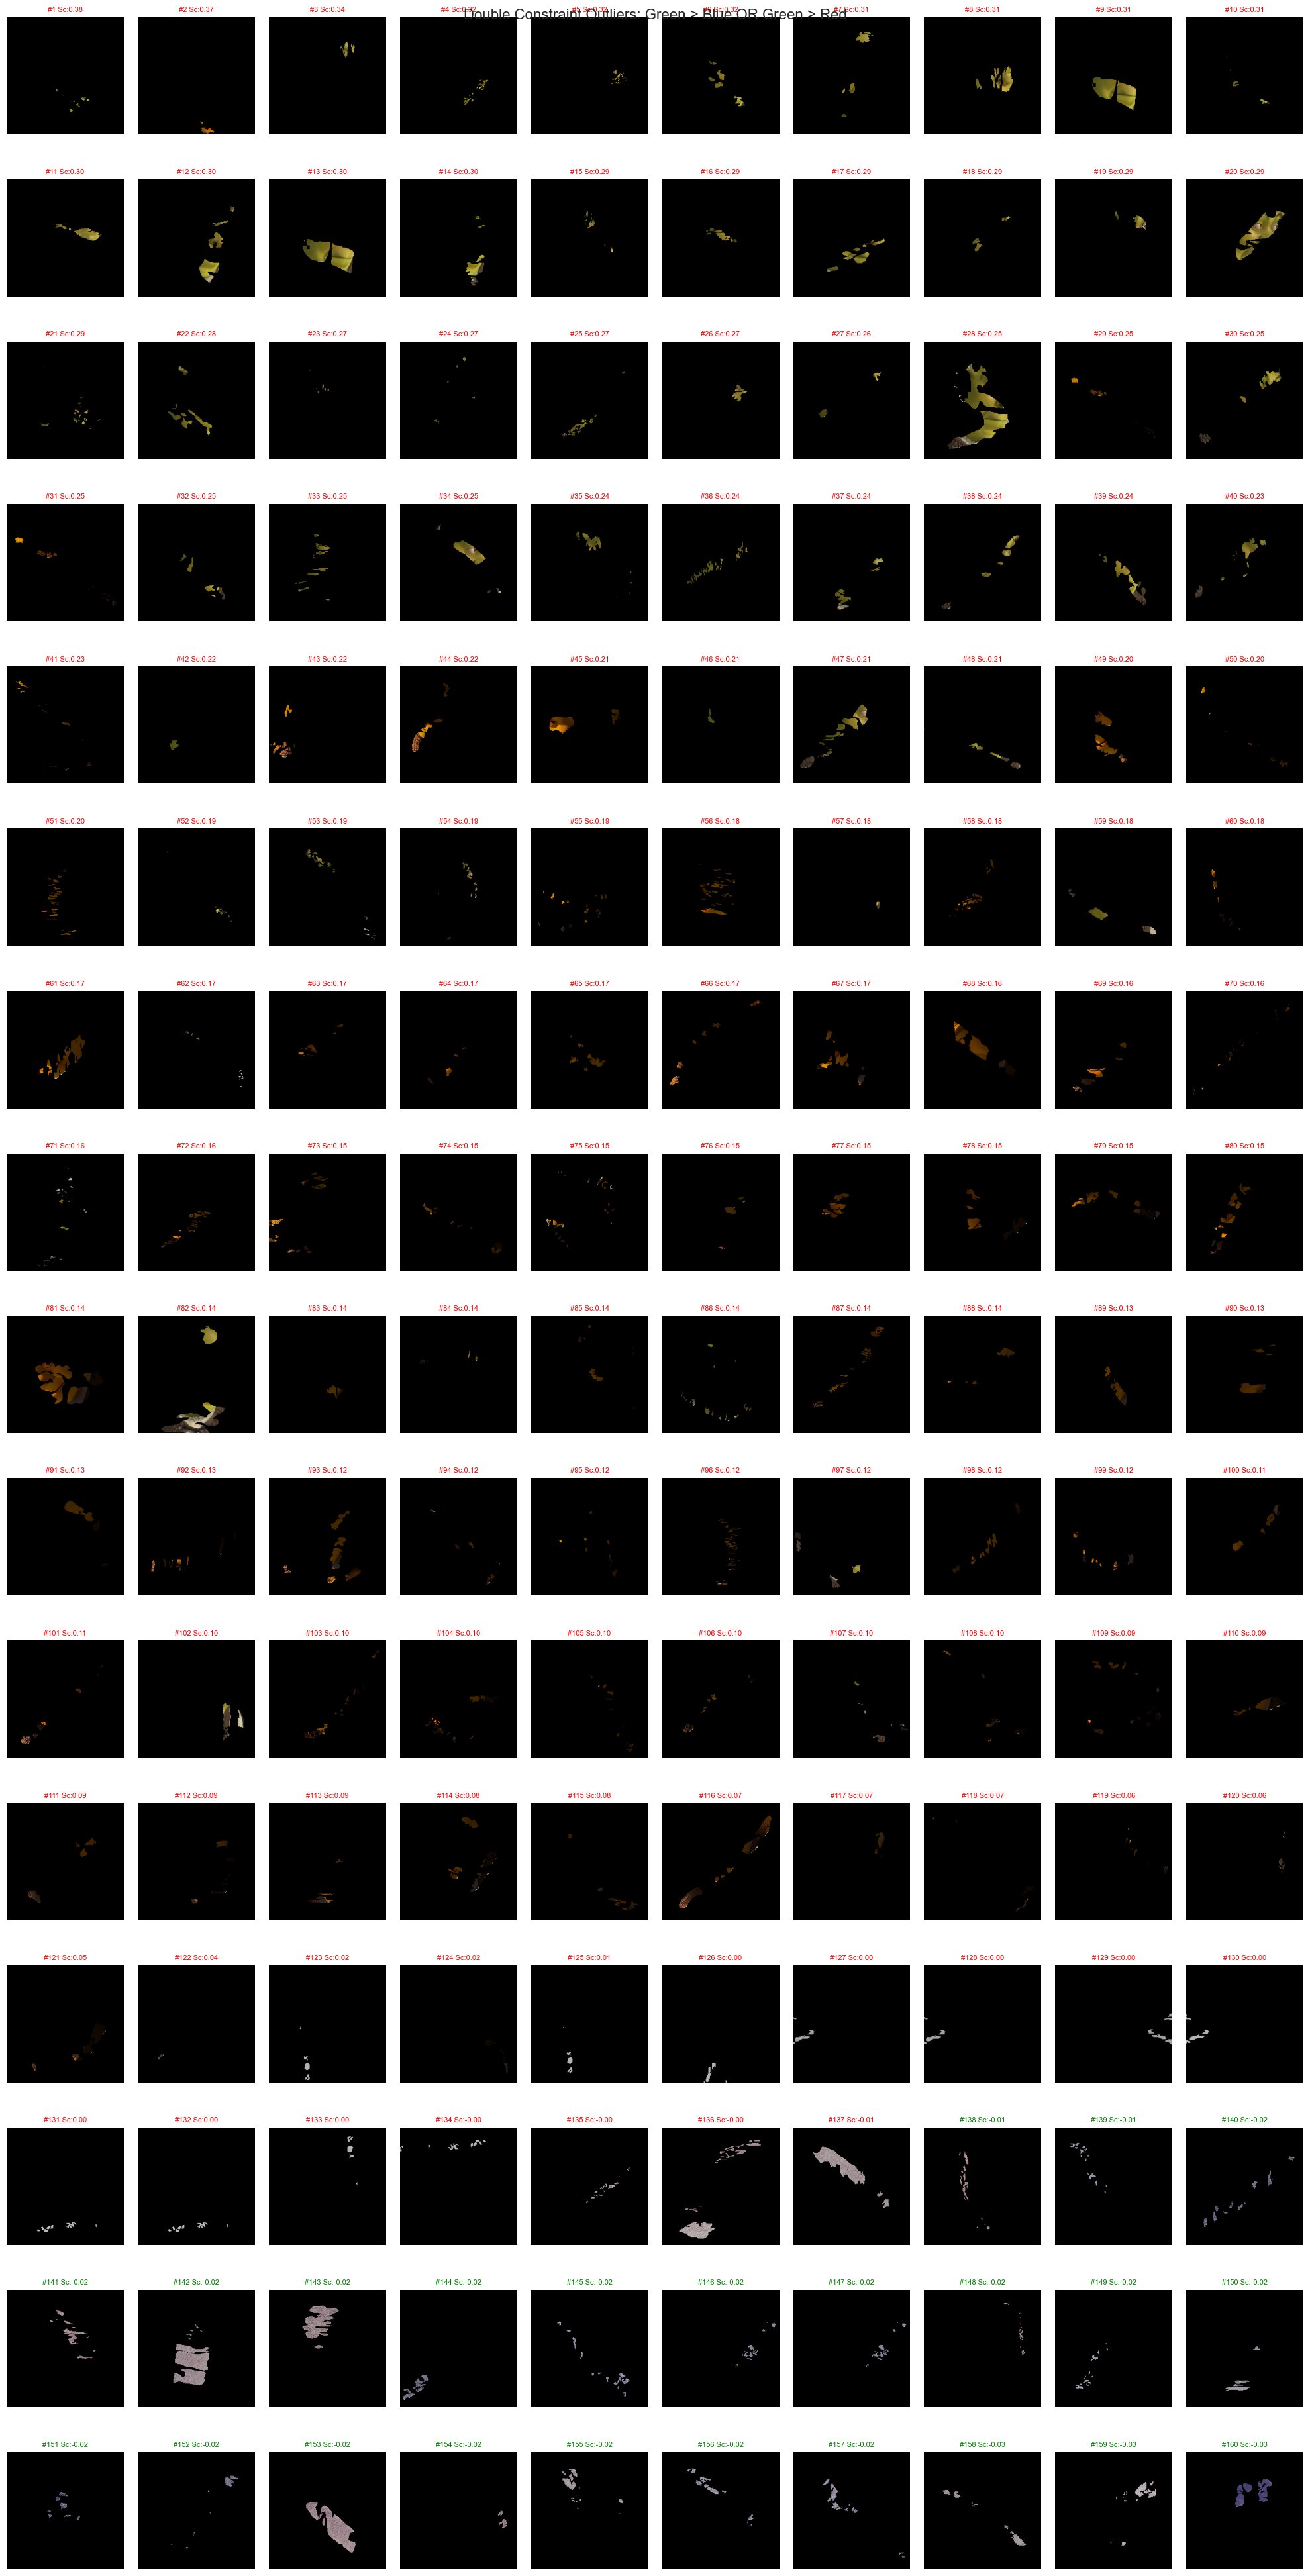

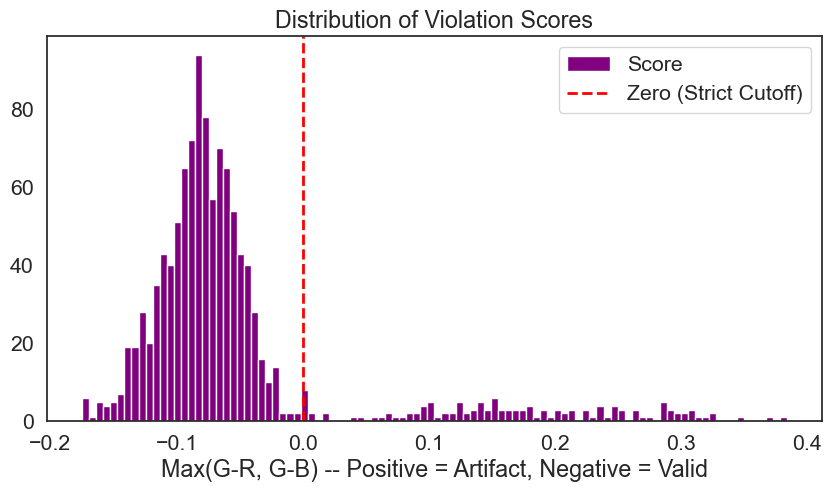

In [131]:
import numpy as np
import matplotlib.pyplot as plt

# X_train is (N, 224, 224, 3) in range [0, 1]

def calculate_violation_scores(images):
    scores = []
    
    for img in images:
        # 1. Strict Content Mask (Ignore Black Background)
        # Sum > 0.1 removes the black masked area.
        # Sum < 2.95 removes pure white background (if any remains).
        rgb_sum = np.sum(img, axis=2)
        content_mask = (rgb_sum > 0.1) & (rgb_sum < 2.95)
        
        # If image is effectively empty, give it a "Safe" score
        if np.sum(content_mask) == 0:
            scores.append(-1.0)
            continue
            
        valid_pixels = img[content_mask]
        
        # 2. Calculate Channel Means for TISSUE only
        mean_r = np.mean(valid_pixels[:, 0])
        mean_g = np.mean(valid_pixels[:, 1])
        mean_b = np.mean(valid_pixels[:, 2])
        
        # 3. The Double Constraint
        # Constraint 1: Green must be less than Blue (Checks for Brown/Orange/Green)
        violation_vs_blue = mean_g - mean_b
        
        # Constraint 2: Green must be less than Red (Checks for Teal/Cyan/Green)
        violation_vs_red = mean_g - mean_r
        
        # 4. The "Worst Case" Score
        # If EITHER constraint is violated, the score goes high.
        # Valid cells will have both values negative.
        final_score = max(violation_vs_blue, violation_vs_red)
        
        scores.append(final_score)
        
    return np.array(scores)

# Run the filter
print("Checking for Biological Constraints (Green must be weakest)...")
outlier_scores = calculate_violation_scores(X_train)

# Sort: Positive scores are artifacts. Negative scores are cells.
sorted_indices = np.argsort(outlier_scores)[::-1]

# Display top 160
N_SHOW = 160
cols = 10
rows = N_SHOW // cols

plt.figure(figsize=(20, 2.5 * rows))
plt.suptitle("Double Constraint Outliers: Green > Blue OR Green > Red", fontsize=16)

for i in range(N_SHOW):
    idx = sorted_indices[i]
    ax = plt.subplot(rows, cols, i + 1)
    
    # Clip for display
    ax.imshow(np.clip(X_train[idx], 0, 1))
    
    # Title
    score = outlier_scores[idx]
    
    # Threshold Logic:
    # 0.0 is the theoretical limit.
    # > 0.00: Definitely not standard H&E
    # < -0.02: Safely H&E
    color = 'red' if score > -0.01 else 'green'
    
    ax.set_title(f"#{i+1} Sc:{score:.2f}", fontsize=8, color=color)
    ax.axis('off')

plt.tight_layout()
plt.show()

# Distribution Plot
plt.figure(figsize=(10, 5))
plt.hist(outlier_scores, bins=100, color='purple', label='Score')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero (Strict Cutoff)')
plt.title('Distribution of Violation Scores')
plt.xlabel('Max(G-R, G-B) -- Positive = Artifact, Negative = Valid')
plt.legend()
plt.show()